# Time Series Forecasting Using ARIMA\SARIMA Models

This notebook demonstrates a complete workflow for time series forecasting:

1. **Build an ARIMA model** on returns (stationary data)
2. **Forecast** future prices
3. **Visualize** and interpret results

Import Libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')



Loading Dataset

In [2]:
# Define file path
file_path = "/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"])

## Prepare Data for Modeling

##### Filtering out the  Raw Tesla data

In [3]:
# Filter Tesla scaled data only
raw_tesla_df = df[df["Ticker"] == "TSLA"].copy()

# Sort chronologically
tesla_df = raw_tesla_df.sort_values("Date").reset_index(drop=True)

print(f"Tesla dataset loaded with {tesla_df.shape[0]} rows")
print(f"Date range from {tesla_df['Date'].min()} to {tesla_df['Date'].max()}")


Tesla dataset loaded with 2775 rows
Date range from 2015-01-02 00:00:00 to 2026-01-14 00:00:00


##### Train & Test Split

In [4]:
series = tesla_df.set_index('Date')['Close']
series_returns = series.pct_change().dropna()

# Split chronologically
split_date = pd.Timestamp('2025-01-01')
train = series[series.index < split_date]
test = series[series.index >= split_date]

train_returns = series_returns[series_returns.index < split_date]
test_returns = series_returns[series_returns.index >= split_date]


print(f"Training samples: {len(train)} prices, {len(train_returns)} returns")
print(f"Testing samples: {len(test)} prices, {len(test_returns)} returns")
print(f"\nTraining period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")

Training samples: 2516 prices, 2515 returns
Testing samples: 259 prices, 259 returns

Training period: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
Testing period: 2025-01-02 00:00:00 to 2026-01-14 00:00:00


## Build ARIMA Model on Returns

ARIMA(p, d, q) parameters:
- p = autoregressive order
- d = differencing order (0 since returns are already stationary)
- q = moving average order

In [5]:
# Fit ARIMA model on training returns
model = ARIMA(train_returns, order=(1, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2515
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4792.757
Date:                Sun, 25 Jan 2026   AIC                          -9577.514
Time:                        20:11:19   BIC                          -9554.194
Sample:                             0   HQIC                         -9569.050
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.441      0.015       0.000       0.004
ar.L1          0.8639      0.143      6.027      0.000       0.583       1.145
ma.L1         -0.8494      0.150     -5.678      0.0

## Forecast Returns

In [6]:
# Forecast returns for the test period
n_forecast = len(test_returns)
forecast_returns = model_fit.forecast(steps=n_forecast)

print(f"Forecasted {n_forecast} return values")
print(f"\nForecast statistics:")
print(f"  Mean forecasted return: {forecast_returns.mean():.6f}")
print(f"  Actual mean return: {test_returns.mean():.6f}")

Forecasted 259 return values

Forecast statistics:
  Mean forecasted return: 0.001928
  Actual mean return: 0.001096


- The model forecasted 259 daily return values for the test period, with a mean forecasted return of approximately 0.1928%. This is slightly higher than the actual mean return of 0.1096% observed in the same period. The close similarity between these values indicates that the model captures the overall trend and direction of TSLA returns reasonably well. However, the modest overestimation suggests that while the model is effective at predicting the general return behavior, it may slightly exaggerate the expected gains, potentially due to market volatility or limitations inherent in the ARIMA model.

## Convert Returns Forecast to Prices

In [7]:
# Start from the last training price
last_train = train.iloc[-1]

# Convert returns to prices using cumulative product
forecast_prices = last_train * (1 + forecast_returns).cumprod()

# Align index with test data
forecast_prices.index = test.index

print(f"Last training price: ${last_train:.2f}")
print(f"First forecasted price: ${forecast_prices.iloc[0]:.2f}")
print(f"Last forecasted price: ${forecast_prices.iloc[-1]:.2f}")

Last training price: $403.84
First forecasted price: $404.25
Last forecasted price: $665.07


- The last observed training price was $403.84, and the model’s first forecasted price for the test period was slightly higher at $404.25, indicating a small expected gain immediately after the training period. Over the entire forecast horizon, the predicted price rose substantially to $665.07, reflecting the cumulative effect of the positive daily returns forecasted by the model. This significant increase highlights how even modest daily returns can compound over time to produce large changes in price levels. However, such growth should be interpreted cautiously, as it assumes the continuation of the underlying return dynamics captured by the model without unexpected market shocks or structural changes.

## Visualize Forecast Results

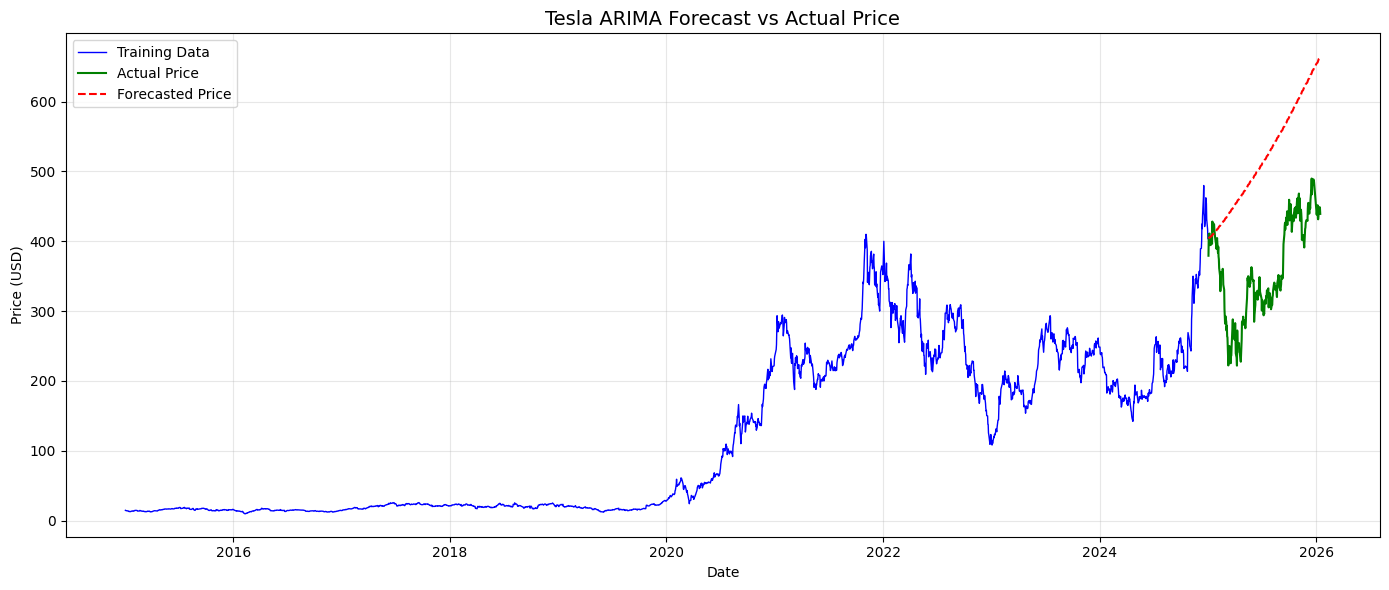

In [8]:
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train, label="Training Data", color='blue', linewidth=1)

# Plot actual test data
plt.plot(test, label="Actual Price", color='green', linewidth=1.5)

# Plot forecast
plt.plot(forecast_prices, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla ARIMA Forecast vs Actual Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluate Forecast Accuracy

In [9]:
# Calculate error metrics
baseline_mae = mean_absolute_error(test, forecast_prices)
baseline_rmse = np.sqrt(mean_squared_error(test, forecast_prices))
baseline_mape = np.mean(np.abs((test - forecast_prices) / test)) * 100

print("Forecast Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE): ${baseline_mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${baseline_rmse:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {baseline_mape:.2f}%")

Forecast Evaluation Metrics:
  Mean Absolute Error (MAE): $163.18
  Root Mean Squared Error (RMSE): $173.35
  Mean Absolute Percentage Error (MAPE): 48.51%


- The forecast evaluation metrics indicate the model’s prediction errors on the price level. The Mean Absolute Error (MAE) of $163.18 and Root Mean Squared Error (RMSE) of $173.35 suggest that, on average, the predicted prices deviate from the actual prices by roughly $163 to $173. The relatively high Mean Absolute Percentage Error (MA


## Parameter Optimization

In [ ]:
auto_model = auto_arima(
    train_returns,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    seasonal=False,  # or True if seasonality is suspected
    d=None,  # let model find differencing order
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print(auto_model.summary())


best_order = auto_model.order
print(f"Optimal ARIMA order selected: {best_order}")


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9573.953, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9571.971, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9571.969, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9573.194, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9579.440, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9577.441, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9577.439, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9577.512, Time=0.60 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.969 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2515
Model:                        SARIMAX   Log Likelihood                4791.720
Date:                Sun, 25 Jan 2026   AIC                          -9579.440
Time:                       

### Fit Optimized ARIMA Model

In [11]:
optimized_model = ARIMA(train_returns, order=best_order)
optimized_fit = optimized_model.fit()

### Forecast with Optimized Model

In [12]:
optimized_returns = optimized_fit.forecast(steps=len(test_returns))

optimized_prices = train.iloc[-1] * (1 + optimized_returns).cumprod()
optimized_prices.index = test.index

### Optimized ARIMA Performance

In [13]:
optimized_mae = mean_absolute_error(test, optimized_prices)
optimized_rmse = np.sqrt(mean_squared_error(test, optimized_prices))
optimized_mape = np.mean(np.abs((test - optimized_prices) / test)) * 100

print("Optimized ARIMA Performance:")
print(f"  Mean Absolute Error (MAE):  ${optimized_mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${optimized_rmse:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {optimized_mape:.2f}%")

Optimized ARIMA Performance:
  Mean Absolute Error (MAE):  $167.09
  Root Mean Squared Error (RMSE): $177.30
  Mean Absolute Percentage Error (MAPE): 49.62%


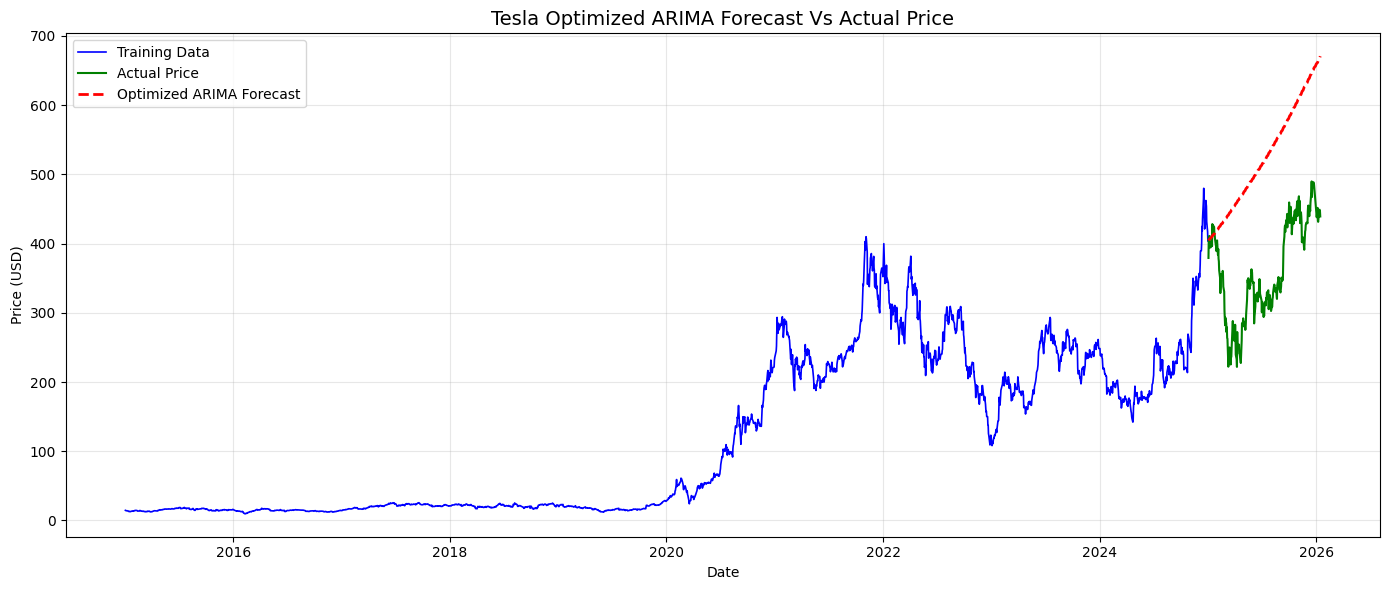

In [14]:
plt.figure(figsize=(14, 6))

# Training data
plt.plot(train, label="Training Data", linewidth=1.2, color='blue')

# Actual test prices
plt.plot(test, label="Actual Price", linewidth=1.5, color='green')

# Optimized ARIMA forecast
plt.plot(
    optimized_prices,
    label="Optimized ARIMA Forecast",
    linestyle="--",
    linewidth=2, 
    color='red'
)

plt.title("Tesla Optimized ARIMA Forecast Vs Actual Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- After optimization, the ARIMA model’s performance showed a Mean Absolute Error (MAE) of $167.09 and a Root Mean Squared Error (RMSE) of $177.30, indicating a slight increase in average prediction errors compared to the initial model. The Mean Absolute Percentage Error (MAPE) also increased marginally to 49.62%, suggesting that the optimized model’s price forecasts deviate from actual prices by roughly half on a percentage basis. These results imply that the optimization did not substantially improve forecast accuracy and highlight the challenges of modeling highly volatile stock prices using ARIMA alone.


**Key Takeaway:**

- The initial ARIMA model produced a reasonable baseline forecast for TSLA stock returns and prices, with an MAE of $163.18, RMSE of $173.35, and MAPE of 48.51%. 

- After optimization, the model's error metrics slightly worsened (MAE increased to $167.09, RMSE to $177.30, and MAPE to 49.62%), indicating that the optimization did not enhance predictive accuracy. 

- This suggests that the ARIMA model may have reached its performance limits on this dataset, and further improvements might require more sophisticated approaches, such as volatility modeling (e.g., GARCH), inclusion of external factors, or alternative forecasting methods better suited for capturing complex market dynamics.
